# Agri-Vision: Plant Diseases Classification & Detection

### Import Useful Library

In [2]:
import os
import re
import copy
from collections import defaultdict
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from PIL import Image
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
import torchvision.models as tv_models

from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

### Load the Dataset

In [3]:
# Normalize helper
def normalize_string(s):
    return re.sub(r'[^a-zA-Z0-9]', '', s).lower()

# Keyword map: maps simplified test image prefixes to full class names
keyword_map = {
    "applecedarrust": "Apple___Cedar_apple_rust",
    "applescab": "Apple___Apple_scab",
    "corncommonrust": "Corn_(maize)___Common_rust_",
    "potatoearlyblight": "Potato___Early_blight",
    "potatohealthy": "Potato___healthy",
    "tomatoearlyblight": "Tomato___Early_blight",
    "tomatohealthy": "Tomato___healthy",
    "tomatoyellowcurlvirus": "Tomato___Tomato_Yellow_Leaf_Curl_Virus"
}

def get_image_paths(base_dir):
    """
    Reads image paths from dataset folders and organizes them into a dictionary:
    dict[split][class_name] = list of image paths
    """
    dataset_dict = defaultdict(lambda: defaultdict(list))

    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(base_dir, split)
        if not os.path.isdir(split_dir):
            print(f"Warning: '{split}' directory not found in {base_dir}")
            continue

        if split == 'test':
            for filename in os.listdir(split_dir):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    img_path = os.path.join(split_dir, filename)
                    img_id = os.path.splitext(filename)[0]
                    img_token = normalize_string(img_id)

                    matched = False
                    for keyword, class_name in keyword_map.items():
                        if keyword in img_token:
                            dataset_dict['test'][class_name].append(img_path)
                            matched = True
                            break
                    if not matched:
                        dataset_dict['test']['Unknown'].append(img_path)
        else:
            for class_name in os.listdir(split_dir):
                class_dir = os.path.join(split_dir, class_name)
                if not os.path.isdir(class_dir):
                    continue
                for filename in os.listdir(class_dir):
                    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        image_path = os.path.join(class_dir, filename)
                        dataset_dict[split][class_name].append(image_path)

    return dict(dataset_dict)

base_dataset_path = "Plant Diseases Dataset"
image_dict = get_image_paths(base_dataset_path)

# Collect class names from all splits
all_classes = set()
all_classes.update(image_dict['train'].keys())
all_classes.update(image_dict['valid'].keys())
all_classes.update(image_dict['test'].keys())

# Build table rows
table = []
for cls in sorted(all_classes):
    train_count = len(image_dict['train'].get(cls, []))
    valid_count = len(image_dict['valid'].get(cls, []))
    test_count = len(image_dict['test'].get(cls, []))
    table.append([cls, train_count, valid_count, test_count])

# Print as table
print("📊 Dataset Class Distribution:\n")
print(tabulate(table, headers=["Class Name", "Train Images", "Valid Images", "Test Images"], tablefmt="github"))

📊 Dataset Class Distribution:

| Class Name                                         |   Train Images |   Valid Images |   Test Images |
|----------------------------------------------------|----------------|----------------|---------------|
| Apple___Apple_scab                                 |           2016 |            504 |             3 |
| Apple___Black_rot                                  |           1987 |            497 |             0 |
| Apple___Cedar_apple_rust                           |           1760 |            440 |             4 |
| Apple___healthy                                    |           2008 |            502 |             0 |
| Blueberry___healthy                                |           1816 |            454 |             0 |
| Cherry_(including_sour)___Powdery_mildew           |           1683 |            421 |             0 |
| Cherry_(including_sour)___healthy                  |           1826 |            456 |             0 |
| Corn_(maize)___Cercosp

### Filter the Dataset

In [4]:
selected_classes = [
    "Apple___Apple_scab",
    "Apple___Cedar_apple_rust",
    "Corn_(maize)___Common_rust_",
    "Potato___Early_blight",
    "Potato___healthy",
    "Tomato___Early_blight",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato___healthy"
]

# Label map for disease classes
label_map = {
    0: 'Apple scab',
    1: 'Apple Cedar rust',
    2: 'Corn Common rust ',
    3: 'Potato Early Blight',
    4: 'Potato Healthy',
    5: 'Tomato Early Blight',
    6: 'Tomato Yellow Leaf Curl Virus',
    7: 'Tomato Healthy'
}

# Filter the image_dict to include only selected classes
def filter_image_dict(original_dict, selected_classes):
    filtered = {}
    for split in ['train', 'valid', 'test']:
        filtered[split] = {}
        for cls in selected_classes:
            filtered[split][cls] = original_dict[split].get(cls, [])
    return filtered

filtered_image_dict = filter_image_dict(image_dict, selected_classes)

### Data Visualization

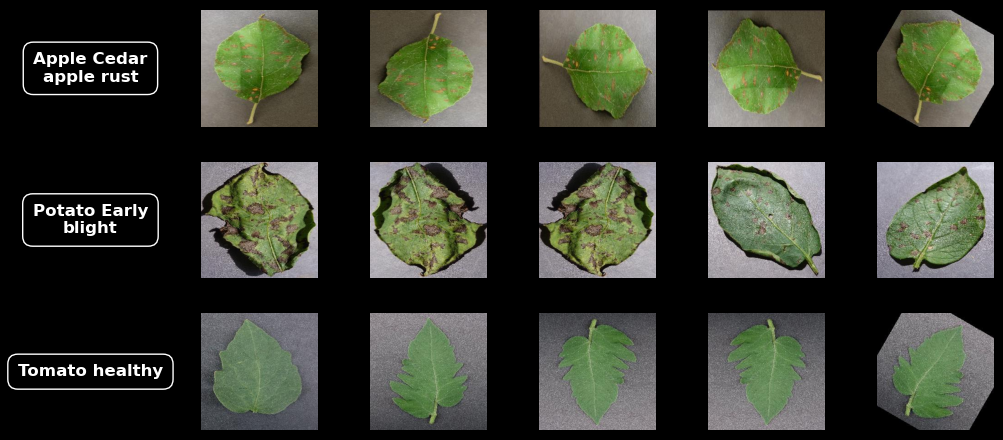

In [5]:
def show_samples_multiple_classes(image_dict, classes, samples_per_class=5):
    """
    Display sample images from multiple classes in a clean grid with black background,
    class names shown as bold labels in the left column, styled with enhanced formatting.
    """
    n_classes = len(classes)
    cols = samples_per_class + 1
    rows = n_classes
    label_col_width = 3
    image_col_width = 1.5
    fig_width = label_col_width + samples_per_class * image_col_width
    fig_height = rows * 1.5
    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height), facecolor='black')

    if rows == 1: axes = [axes]

    for row_idx, cls in enumerate(classes):
        image_paths = image_dict['train'].get(cls, [])
        n_images = min(samples_per_class, len(image_paths))

        # Format class label
        clean_cls = cls.replace('___', '\n').replace('_', ' ')
        wrapped_cls = '\n'.join(textwrap.wrap(clean_cls, width=16))

        # First column: class name
        ax = axes[row_idx][0]
        ax.set_facecolor('black')
        ax.text(0.5, 0.5, wrapped_cls, fontsize=12, weight='bold', color='white', ha='center', va='center', wrap=True, 
                bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.6'), fontname='DejaVu Sans')
        ax.axis('off')

        # Sample images
        for col_idx in range(1, cols):
            ax = axes[row_idx][col_idx]
            ax.set_facecolor('black')
            if col_idx - 1 < n_images:
                img = Image.open(image_paths[col_idx - 1]).convert('RGB')
                ax.imshow(img)
            else:
                ax.imshow([[0, 0], [0, 0]], cmap='gray', vmin=0, vmax=1)
            ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.3)
    plt.show()

classes_to_show = ['Apple___Cedar_apple_rust', 'Potato___Early_blight', 'Tomato___healthy']
show_samples_multiple_classes(filtered_image_dict, classes_to_show, samples_per_class=5)

### Data Preprocessing

In [6]:
# Custom Dataset
class PlantDiseaseDataset(Dataset):
    def __init__(self, image_dict_split, transform=None):
        self.image_paths = []
        self.labels = []
        self.classes = sorted(image_dict_split.keys())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.transform = transform

        for cls, imgs in image_dict_split.items():
            for img_path in imgs:
                self.image_paths.append(img_path.replace("\\", "/"))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225]),
])

# Prepare datasets
train_dataset = PlantDiseaseDataset(filtered_image_dict['train'], transform=train_transform)
valid_dataset = PlantDiseaseDataset(filtered_image_dict['valid'], transform=test_transform)
test_dataset  = PlantDiseaseDataset(filtered_image_dict['test'], transform=test_transform)

print("="*60)
print("📊 Dataset Summary".center(60))
print("="*60)

# Number of Classes
num_classes = len(train_dataset.classes)
print(f"🧾 Total Classes: {num_classes}")

# Class-to-Index Mapping (show first 5)
print("\n🔤 Class-to-Index Mapping:")
for k, v in list(train_dataset.class_to_idx.items())[:]:
    print(f"   {v:2d} → {k}")

# Dataset Sizes
print("\n🗂️ Dataset Sizes:")
print(f"   🟢 Training Samples  : {len(train_dataset)}")
print(f"   🔵 Validation Samples: {len(valid_dataset)}")
print(f"   🟣 Test Samples      : {len(test_dataset)}")

print("\n🖼️ Verifying First Image Sample")
img, label = train_dataset[0]
print(f"   📐 Image Shape: {tuple(img.shape)}")   # (C, H, W)
print(f"   🏷️  Label Index: {label}")
print(f"   🧾 Label Name : {train_dataset.classes[label]}")

print("="*60)

                     📊 Dataset Summary                      
🧾 Total Classes: 8

🔤 Class-to-Index Mapping:
    0 → Apple___Apple_scab
    1 → Apple___Cedar_apple_rust
    2 → Corn_(maize)___Common_rust_
    3 → Potato___Early_blight
    4 → Potato___healthy
    5 → Tomato___Early_blight
    6 → Tomato___Tomato_Yellow_Leaf_Curl_Virus
    7 → Tomato___healthy

🗂️ Dataset Sizes:
   🟢 Training Samples  : 15253
   🔵 Validation Samples: 3813
   🟣 Test Samples      : 33

🖼️ Verifying First Image Sample
   📐 Image Shape: (3, 224, 224)
   🏷️  Label Index: 0
   🧾 Label Name : Apple___Apple_scab


### Train the models

###### Early Settings

In [7]:
# Class for Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters for hyper-parameter tuning in pre-trained models
learning_rate = 1e-4
weight_decay = 1e-5

num_classes = len(train_dataset.classes)

Using device: cuda


###### 1) Baseline custom CNN model

In [8]:
# ----------- Custom CNN Model --------------
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),     # input: 3x224x224, output: 32x224x224
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),               # output: 32x222x222
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                             # output: 32x111x111

            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # 64x111x111
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),               # 64x109x109
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                             # 64x54x54

            nn.Conv2d(64, 128, kernel_size=3, padding=1),   # 128x54x54
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),             # 128x52x52
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                             # 128x26x26

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 256x26x26
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3),             # 256x24x24
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                             # 256x12x12
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(256 * 12 * 12, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [9]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs, device):
    early_stopping = EarlyStopping(patience=7, min_delta=0.001)
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        train_loop = tqdm(train_loader, desc='Training', leave=False)
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)
            train_loop.set_postfix(loss=loss.item(), accuracy=running_corrects/total)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total
        print(f"Train Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        val_loop = tqdm(valid_loader, desc='Validation', leave=False)
        with torch.no_grad():
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)
                val_loop.set_postfix(val_loss=loss.item(), val_accuracy=val_corrects/val_total)

        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_corrects / val_total
        print(f"Val Loss: {val_epoch_loss:.4f}  Acc: {val_epoch_acc:.4f}")

        scheduler.step(val_epoch_loss)
        early_stopping(val_epoch_loss)

        # Save best model weights
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'saved_models/baseline_custom_cnn_model.pth')

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    print("Training complete")
    model.load_state_dict(best_model_wts)
    return model


# Initialize baseline custom CNN
model = CustomCNN(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

num_epochs = 5
trained_model = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs, device)


Epoch 1/5
------------------------------


Train Loss: 1.0765  Acc: 0.5971


Val Loss: 0.4710  Acc: 0.8377

Epoch 2/5
------------------------------


Train Loss: 0.3802  Acc: 0.8698


Val Loss: 0.2404  Acc: 0.9182

Epoch 3/5
------------------------------


Train Loss: 0.2229  Acc: 0.9266


Val Loss: 0.1595  Acc: 0.9473

Epoch 4/5
------------------------------


Train Loss: 0.1748  Acc: 0.9443


Val Loss: 0.0876  Acc: 0.9714

Epoch 5/5
------------------------------


Train Loss: 0.1385  Acc: 0.9537


Val Loss: 0.0542  Acc: 0.9827
Training complete


###### 2) Transfer Learning with Resnet50 model

In [10]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs, device):
    early_stopping = EarlyStopping(patience=7, min_delta=0.001)
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        train_loop = tqdm(train_loader, desc='Training', leave=False)
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)
            train_loop.set_postfix(loss=loss.item(), accuracy=running_corrects/total)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total
        print(f"Train Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        val_loop = tqdm(valid_loader, desc='Validation', leave=False)
        with torch.no_grad():
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)
                val_loop.set_postfix(val_loss=loss.item(), val_accuracy=val_corrects/val_total)

        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_corrects / val_total
        print(f"Val Loss: {val_epoch_loss:.4f}  Acc: {val_epoch_acc:.4f}")

        scheduler.step(val_epoch_loss)
        early_stopping(val_epoch_loss)

        # Save best model weights
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'saved_models/transfer_resnet50_model.pth')

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    print("Training complete")
    model.load_state_dict(best_model_wts)
    return model


# Load pretrained ResNet50
model = models.resnet50(pretrained=True)
for param in model.parameters(): param.requires_grad = False     # Freeze all layers
model.fc = nn.Linear(model.fc.in_features, num_classes)          # Replace final layer
for param in model.fc.parameters(): param.requires_grad = True   # Unfreeze final layer it
model.to(device)

# Only train the final classifier layer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

num_epochs = 5
trained_model = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs, device)


Epoch 1/5
------------------------------


Train Loss: 1.0069  Acc: 0.8430


Val Loss: 0.5113  Acc: 0.9499

Epoch 2/5
------------------------------


Train Loss: 0.3913  Acc: 0.9525


Val Loss: 0.2914  Acc: 0.9607

Epoch 3/5
------------------------------


Train Loss: 0.2507  Acc: 0.9634


Val Loss: 0.1958  Acc: 0.9714

Epoch 4/5
------------------------------


Train Loss: 0.1909  Acc: 0.9696


Val Loss: 0.1613  Acc: 0.9730

Epoch 5/5
------------------------------


Train Loss: 0.1544  Acc: 0.9734


Val Loss: 0.1301  Acc: 0.9801
Training complete


###### 3) Fine-tuned Vision Transformer model

In [9]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs, device):
    early_stopping = EarlyStopping(patience=7, min_delta=0.001)
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        train_loop = tqdm(train_loader, desc='Training', leave=False)
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).logits  # ViT returns output in `.logits`
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)
            train_loop.set_postfix(loss=loss.item(), accuracy=running_corrects/total)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total
        print(f"Train Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        val_loop = tqdm(valid_loader, desc='Validation', leave=False)
        with torch.no_grad():
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)
                val_loop.set_postfix(val_loss=loss.item(), val_accuracy=val_corrects/val_total)

        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_corrects / val_total
        print(f"Val Loss: {val_epoch_loss:.4f}  Acc: {val_epoch_acc:.4f}")

        scheduler.step(val_epoch_loss)
        early_stopping(val_epoch_loss)

        # Save best model weights
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'saved_models/fine_tuned_vit_model.pth')

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    print("Training complete")
    model.load_state_dict(best_model_wts)
    return model


# Load pretrained ViT base model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)

num_epochs = 2
trained_model = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs, device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/1
------------------------------


Train Loss: 0.1132  Acc: 0.9799


Val Loss: 0.0202  Acc: 0.9953
Training complete


### Evaluation on Test Data

###### Reload Model Architectures & Load Saved Weights. Prepare Test Dataloader

In [9]:
## a) CustomCNN Model
custom_model = CustomCNN(num_classes=num_classes)
custom_model.load_state_dict(torch.load('saved_models/baseline_custom_cnn_model.pth'))
custom_model.to(device)
custom_model.eval()

## b) Transfer Learning ResNet50
resnet_model = tv_models.resnet50(pretrained=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model.load_state_dict(torch.load('saved_models/transfer_resnet50_model.pth'))
resnet_model.to(device)
resnet_model.eval()

## c) Fine-Tuned Vision Transformer (ViT)
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_classes)
vit_model.load_state_dict(torch.load('saved_models/fine_tuned_vit_model.pth'))
vit_model.to(device)
vit_model.eval()

# Prepare Test DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###### Classification Reports & Test Accuracy

In [10]:
def evaluate_model(model, test_loader, is_vit=False, model_name="Model"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits if is_vit else model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    model_accuracies[model_name] = acc
    print("="*60)
    print(f"📄 Classification Report for {model_name}:")
    print("="*60)
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits=2))

model_accuracies = {}

# Evaluate and print classification reports first
evaluate_model(custom_model, test_loader, is_vit=False, model_name="Custom CNN")
evaluate_model(resnet_model, test_loader, is_vit=False, model_name="ResNet50")
evaluate_model(vit_model, test_loader, is_vit=True, model_name="ViT")

# Now print all accuracies together at the end
print("✅ Test Accuracies Summary:")
acc_df = pd.DataFrame([model_accuracies])
acc_df = acc_df.applymap(lambda x: f"{x:.2f}")
acc_df.head()

📄 Classification Report for Custom CNN:
                                        precision    recall  f1-score   support

                    Apple___Apple_scab       0.50      0.33      0.40         3
              Apple___Cedar_apple_rust       1.00      1.00      1.00         4
           Corn_(maize)___Common_rust_       1.00      1.00      1.00         3
                 Potato___Early_blight       0.83      1.00      0.91         5
                      Potato___healthy       1.00      1.00      1.00         2
                 Tomato___Early_blight       0.83      0.83      0.83         6
Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.71      0.83      0.77         6
                      Tomato___healthy       1.00      0.75      0.86         4

                              accuracy                           0.85        33
                             macro avg       0.86      0.84      0.85        33
                          weighted avg       0.85      0.85      0.84        3

,Custom CNN,ResNet50,ViT
0,0.85,0.94,1.00


###### Confusion Matrices

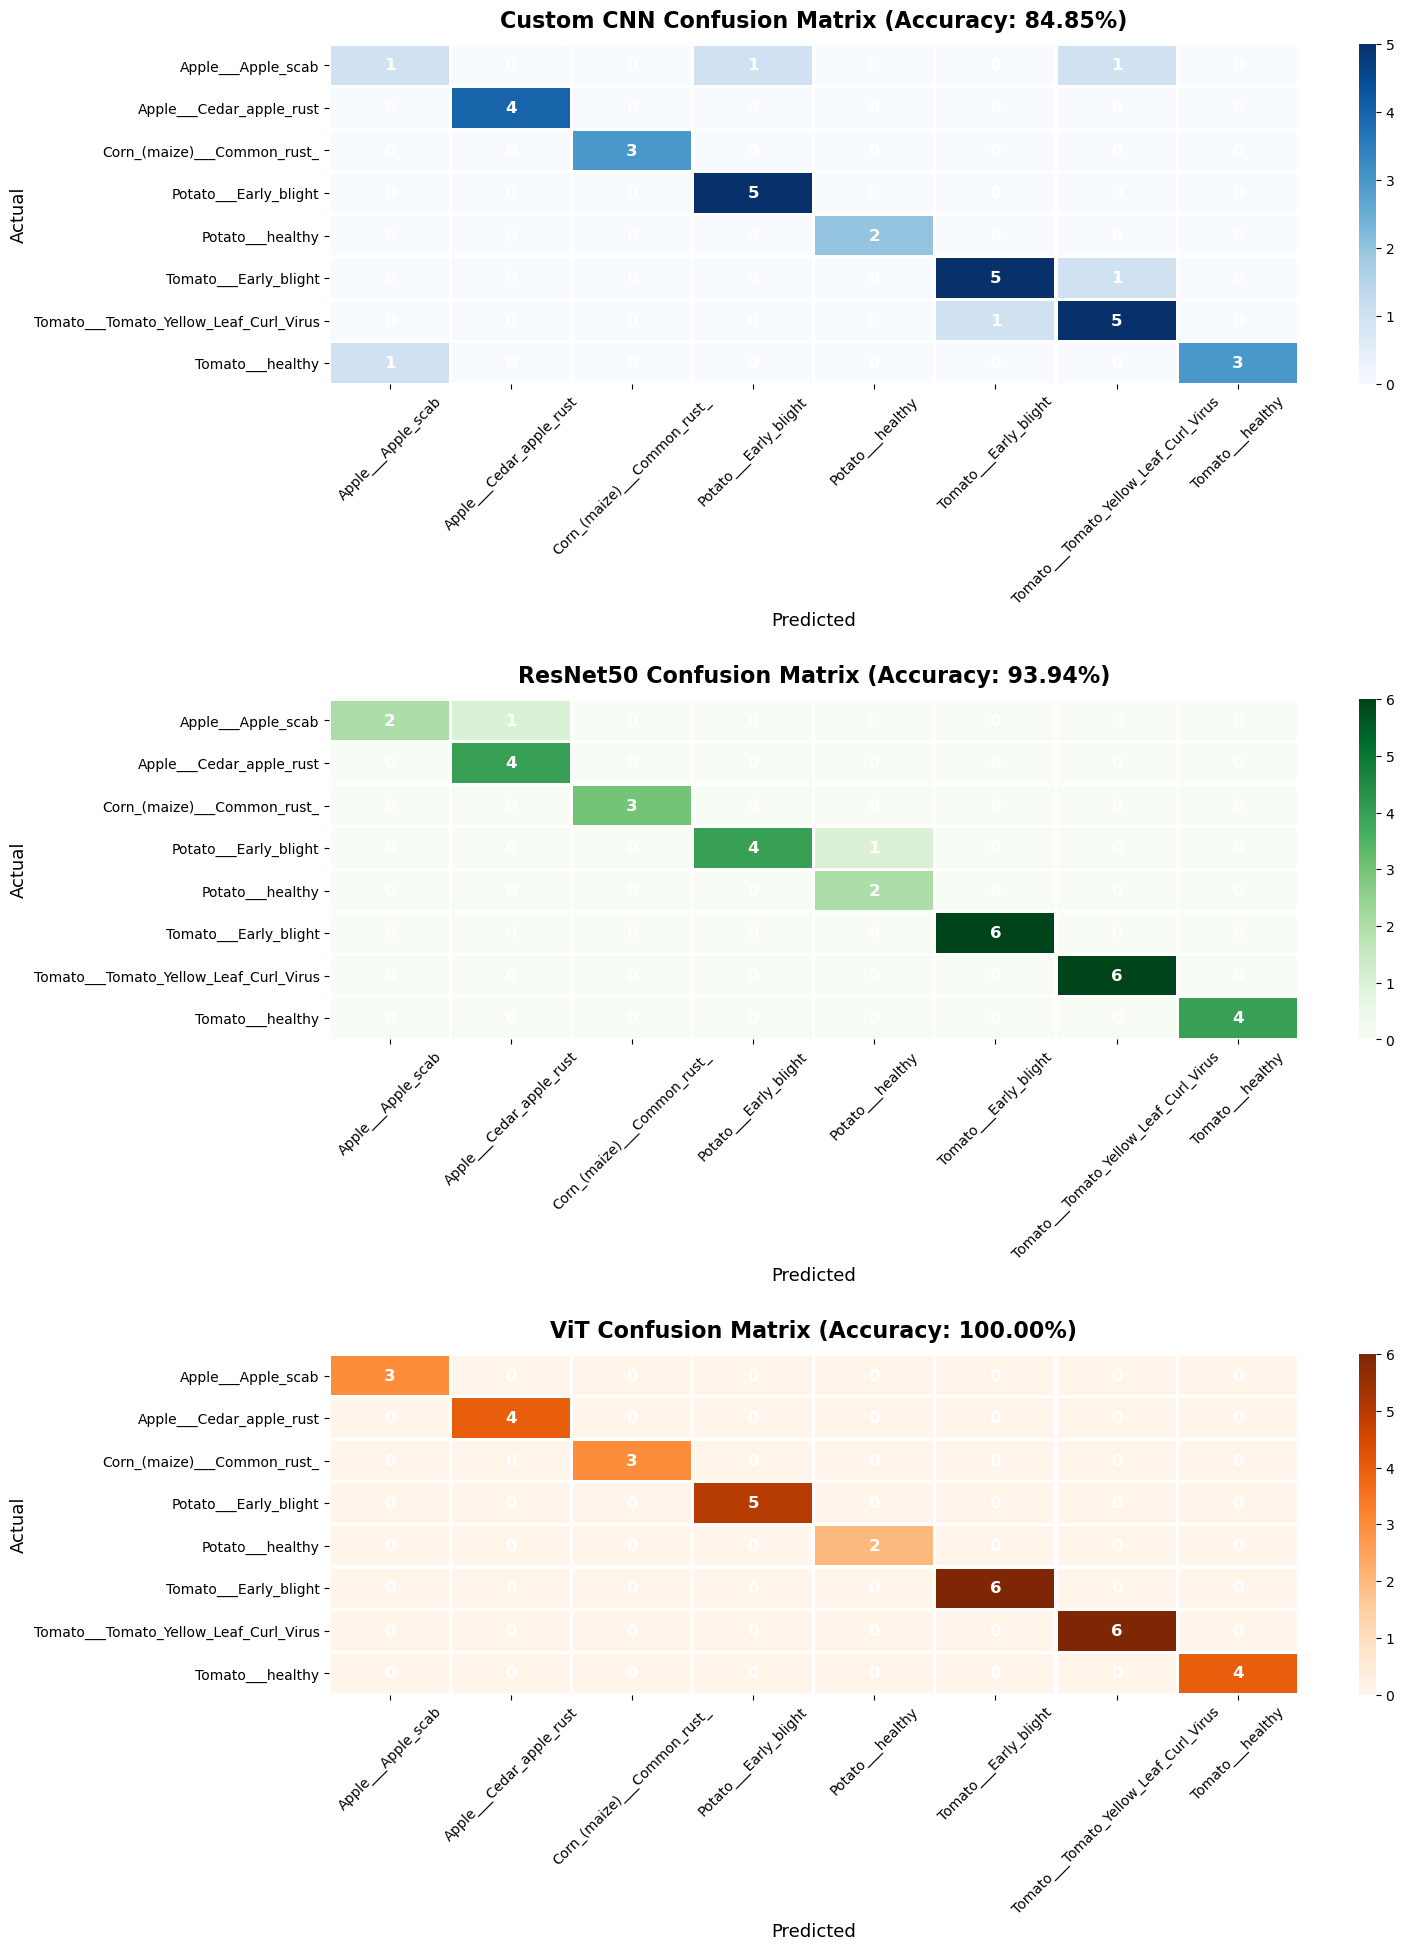

In [11]:
# Get predictions
def get_predictions(model, dataloader, is_vit=False):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits if is_vit else model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Compute predictions and confusion matrices
labels_cnn, preds_cnn = get_predictions(custom_model, test_loader)
labels_resnet, preds_resnet = get_predictions(resnet_model, test_loader)
labels_vit, preds_vit = get_predictions(vit_model, test_loader, is_vit=True)

cm_cnn = confusion_matrix(labels_cnn, preds_cnn)
cm_resnet = confusion_matrix(labels_resnet, preds_resnet)
cm_vit = confusion_matrix(labels_vit, preds_vit)

acc_cnn = accuracy_score(labels_cnn, preds_cnn)
acc_resnet = accuracy_score(labels_resnet, preds_resnet)
acc_vit = accuracy_score(labels_vit, preds_vit)

# Plot them one per row
fig, axes = plt.subplots(3, 1, figsize=(16, 20), dpi=100)

# Custom vibrant colormaps
colormaps = ['Blues', 'Greens', 'Oranges']
titles = [
    f"Custom CNN Confusion Matrix (Accuracy: {acc_cnn:.2%})",
    f"ResNet50 Confusion Matrix (Accuracy: {acc_resnet:.2%})",
    f"ViT Confusion Matrix (Accuracy: {acc_vit:.2%})"
]
cms = [cm_cnn, cm_resnet, cm_vit]
class_names = test_dataset.classes

for ax, cm, cmap, title in zip(axes, cms, colormaps, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, xticklabels=class_names, yticklabels=class_names, cbar=True, 
                linewidths=1.5, linecolor='white', annot_kws={"size": 12, "weight": "bold", "color": "white"})
    ax.set_title(title, fontsize=16, weight='bold', pad=12)
    ax.set_xlabel("Predicted", fontsize=13)
    ax.set_ylabel("Actual", fontsize=13)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout(pad=2.5)
plt.show()

###### Test Results

🔍 Test Results:


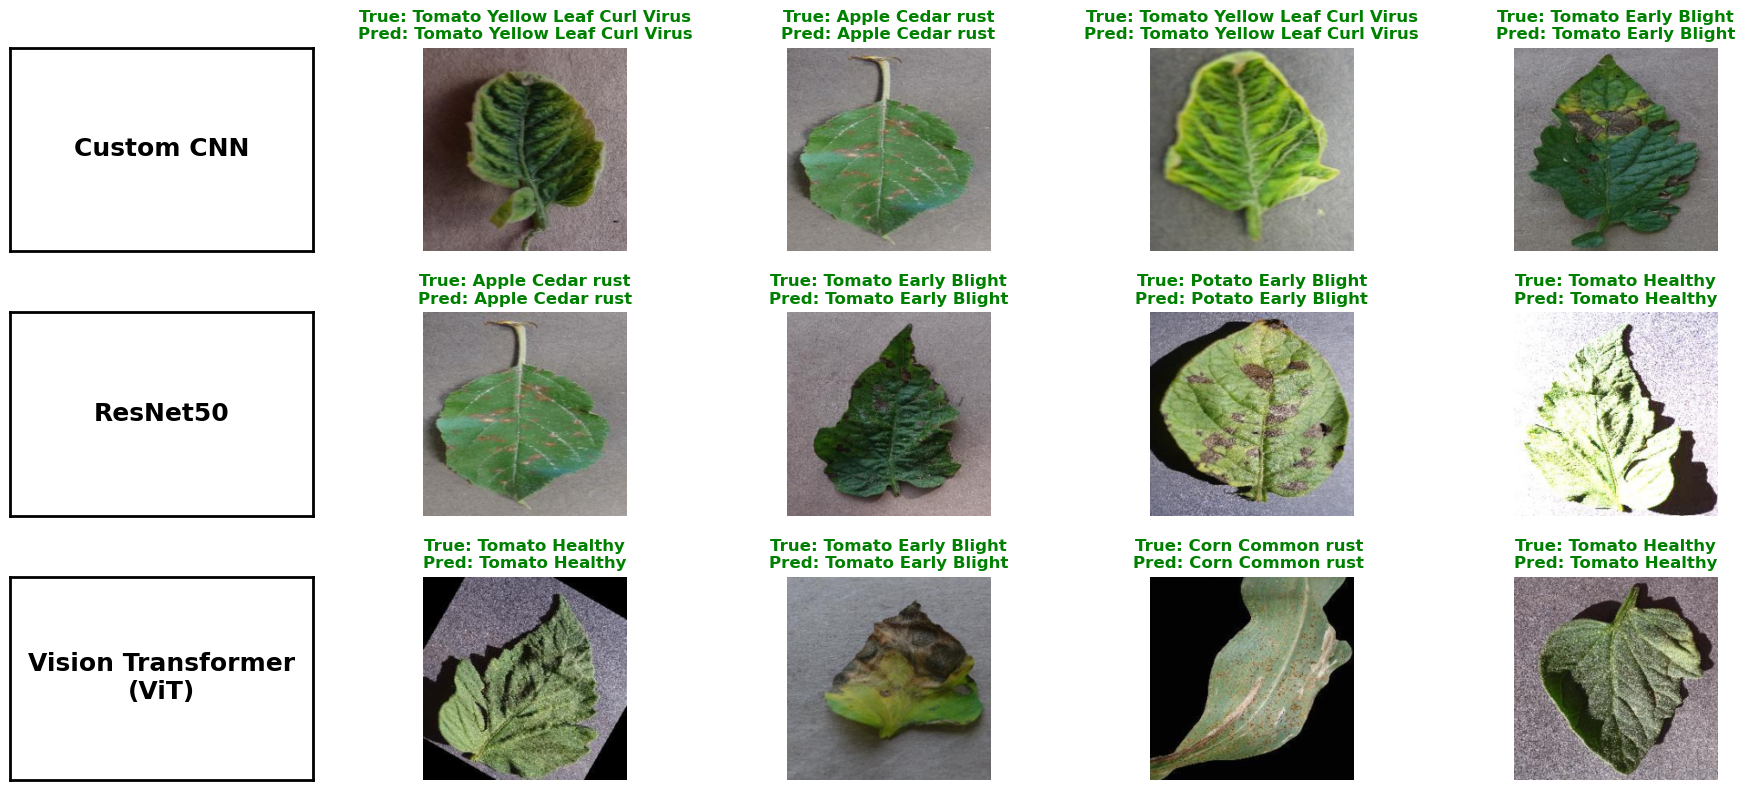

In [12]:
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    return img_tensor * std + mean

def show_sample_predictions_table_style(models, dataset, samples_per_model=4, figsize=(18, 8), fontsize_label=16, 
                                        fontsize_title=11, border_width=3, axis_off=True, show_full_classname=False):
    total_rows = len(models)
    total_cols = samples_per_model + 1
    fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)
    if total_rows == 1: axes = np.expand_dims(axes, axis=0)
    if total_cols == 1: axes = np.expand_dims(axes, axis=1)
    softmax = torch.nn.Softmax(dim=1)
    for row_idx, (model, is_vit, model_name) in enumerate(models):
        model.eval()
        indices = np.random.choice(len(dataset), size=samples_per_model, replace=False)
        label_ax = axes[row_idx, 0]
        label_ax.set_facecolor('white')
        wrapped_name = '\n'.join(textwrap.wrap(model_name, width=20))
        label_ax.text(0.5, 0.5, wrapped_name, fontsize=fontsize_label, weight='bold', color='black', 
                      ha='center', va='center', wrap=True)
        label_ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        for spine in label_ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(2)
        label_ax.set_xticks([])
        label_ax.set_yticks([])
        for col_idx, sample_idx in enumerate(indices, start=1):
            ax = axes[row_idx, col_idx]
            img, label = dataset[sample_idx]
            input_tensor = img.unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_tensor).logits if is_vit else model(input_tensor)
                pred = output.argmax(dim=1).item()
            true_label = label_map[label]
            pred_label = label_map[pred]
            img_disp = unnormalize(img).permute(1, 2, 0).cpu().numpy()
            img_disp = np.clip(img_disp, 0, 1)
            ax.imshow(img_disp)
            edge_color = 'green' if pred == label else 'red'
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_edgecolor(edge_color)
                spine.set_linewidth(border_width)
            title = f"True: {true_label}\nPred: {pred_label}"
            ax.set_title(title, fontsize=fontsize_title, color=edge_color, weight='bold')
            if axis_off:
                ax.axis('off')
            else:
                ax.tick_params(axis='both', which='both', length=0)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    plt.show()

models_to_show = [
    (custom_model, False, "Custom CNN"),
    (resnet_model, False, "ResNet50"),
    (vit_model, True, "Vision Transformer (ViT)"),
]

print("🔍 Test Results:")
show_sample_predictions_table_style(
    models=models_to_show,
    dataset=test_dataset,
    samples_per_model=4,
    figsize=(18, 8),
    fontsize_label=18,
    fontsize_title=12,
    border_width=3,
    axis_off=True,
    show_full_classname=False
)

### Prediction on Unseen Plant Leaf with detection of diseased areas

📊 Model Predictions:

| Model                    | Predicted Class     |   Confidence |
|:-------------------------|:--------------------|-------------:|
| Custom CNN               | Tomato Early Blight |     0.844572 |
| ResNet50                 | Potato Early Blight |     0.653691 |
| Vision Transformer (ViT) | Tomato Early Blight |     0.453258 |


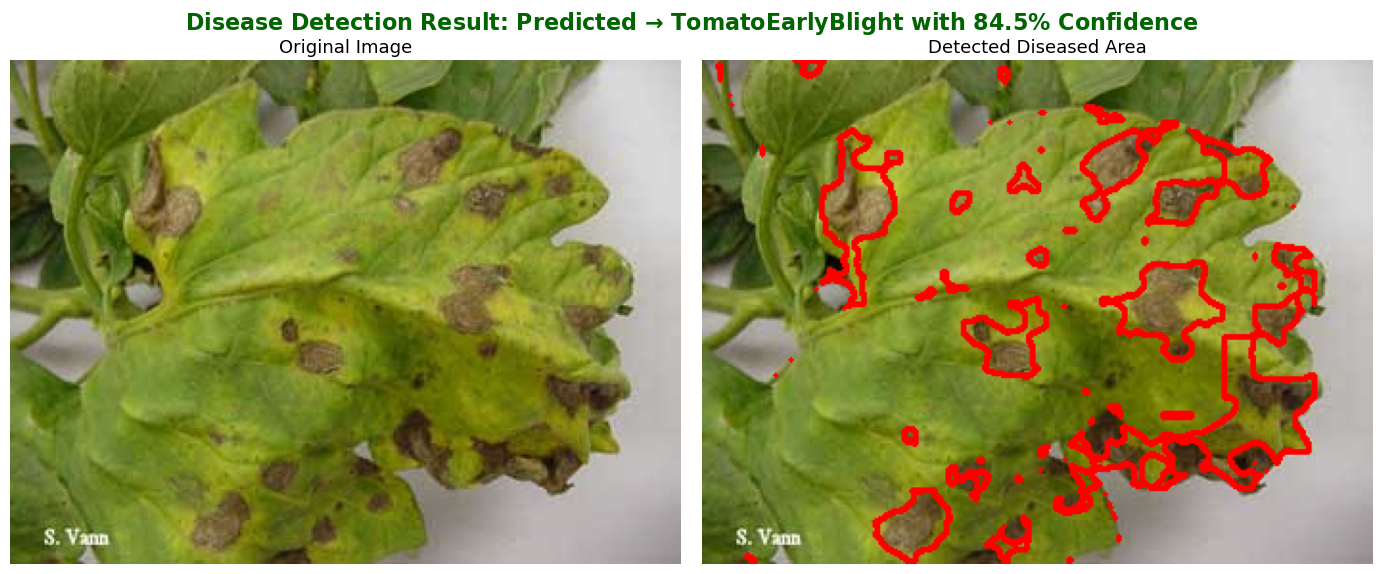

In [13]:
def predict_and_visualize_disease(image_path, models_info, device='cpu'):
    # ----------------------------
    # Part 1: Classification
    # ----------------------------
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225])
    ])

    img_pil = Image.open(image_path).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    results = []

    for model, is_vit, name in models_info:
        model.eval()
        with torch.no_grad():
            outputs = model(img_tensor).logits if is_vit else model(img_tensor)
            probs = F.softmax(outputs, dim=1)
            top_prob, top_idx = torch.max(probs, dim=1)
            class_idx = top_idx.item()
            predicted_class = label_map[class_idx]
            results.append({
                'Model': name,
                'Predicted Class': predicted_class,
                'Confidence': top_prob.item()
            })

    best_result = max(results, key=lambda x: x['Confidence'])

    # ----------------------------
    # Part 2: Color-Based Spot Detection
    # ----------------------------
    image = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_bound = np.array([10, 100, 100])
    upper_bound = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    highlighted = original_rgb.copy()
    cv2.drawContours(highlighted, contours, -1, (255, 0, 0), 2)  # Red contours

    # ----------------------------
    # Part 3: Show Prediction Table
    # ----------------------------
    results_df = pd.DataFrame(results)
    print("📊 Model Predictions:\n")
    print(results_df.to_markdown(index=False))

    # ----------------------------
    # Part 4: Visualization with Title
    # ----------------------------
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(
        f"Disease Detection Result: "
        f"Predicted → "
        f"$\\bf{{{best_result['Predicted Class']}}}$ "
        f"with $\\bf{{{best_result['Confidence']*100:.1f}\\%}}$ Confidence",
        fontsize=16,
        color='darkgreen',
        weight='bold'
    )

    axs[0].imshow(original_rgb)
    axs[0].axis('off')
    axs[0].set_title("Original Image", fontsize=13)

    axs[1].imshow(highlighted)
    axs[1].axis('off')
    axs[1].set_title("Detected Diseased Area", fontsize=13)

    plt.tight_layout(rect=[0, 0.03, 1, 0.92])  # adjust for title spacing
    plt.show()


# ----------------------------
# Example Usage
# ----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

models_to_check = [
    (custom_model, False, "Custom CNN"),
    (resnet_model, False, "ResNet50"),
    (vit_model, True, "Vision Transformer (ViT)")
]

image_path = "Image 1.jpg"
predict_and_visualize_disease(image_path, models_to_check, device=device)

# ***Streamlit App =============================***

In [2]:
code = '''
import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from transformers import ViTForImageClassification
import os
import cv2
import numpy as np
from PIL import Image

# --------------------------
# Set page config FIRST thing after imports
# --------------------------
st.set_page_config(page_title="🌿 Agri-Vision Plant Disease Detector", page_icon="🌿", layout="wide")

# --------------------------
# CSS Styling for all pages
# --------------------------
st.markdown(
    """
    <style>
    /* Import beautiful natural fonts from Google Fonts */
    @import url('https://fonts.googleapis.com/css2?family=Dancing+Script:wght@600&family=Quicksand:wght@400;600&display=swap');

    /* App background */
    .stApp {
        background-color: #e6f4e3;
        font-family: 'Quicksand', sans-serif;
        color: #3e3e3e;
    }

    /* Header styling - natural handwritten look */
    h1, h2, h3 {
        color: #2e7d32;
        font-family: 'Dancing Script', cursive;
    }

    /* Sidebar styling */
    section[data-testid="stSidebar"] {
        background-color: #c8e6c9;
        font-family: 'Quicksand', sans-serif;
    }

    /* Buttons */
    div.stButton > button {
        background-color: #8d6e63;
        color: white;
        border-radius: 12px;
        padding: 0.5em 1em;
        font-weight: bold;
        font-family: 'Quicksand', sans-serif;
        transition: 0.3s ease-in-out;
    }

    div.stButton > button:hover {
        background-color: #6d4c41;
        color: #ffffff;
    }

    /* Markdown text styling */
    .markdown-text-container {
        font-size: 17px;
        line-height: 1.6;
        font-family: 'Quicksand', sans-serif;
        color: #4b3e2f;
    }
    </style>
    """,
    unsafe_allow_html=True
)

# --------------------------
# Label Map with Colors (for badges)
# --------------------------
label_map = {
    0: ('Apple scab', '#F44336'),              # Red
    1: ('Apple Cedar rust', '#FF9800'),        # Orange
    2: ('Corn Common rust ', '#FFC107'),       # Amber
    3: ('Potato Early Blight', '#4CAF50'),     # Green
    4: ('Potato Healthy', '#2196F3'),           # Blue
    5: ('Tomato Early Blight', '#9C27B0'),     # Purple
    6: ('Tomato Yellow Leaf Curl Virus', '#00BCD4'), # Cyan
    7: ('Tomato Healthy', '#8BC34A')            # Light Green
}

# --------------------------
# Custom CNN Model Definition
# --------------------------
class CustomCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(256 * 12 * 12, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# --------------------------
# Helper Functions
# --------------------------
@st.cache(allow_output_mutation=True)
def load_models(device):
    models_dict = {}

    cnn_model = CustomCNN(num_classes=8)
    cnn_model.load_state_dict(torch.load(os.path.join(os.getcwd(), "saved_models", "baseline_custom_cnn_model.pth"), map_location=device))
    cnn_model.to(device).eval()
    models_dict["Custom CNN"] = (cnn_model, False)

    resnet_model = models.resnet50(pretrained=False)
    resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 8)
    resnet_model.load_state_dict(torch.load(os.path.join(os.getcwd(), "saved_models", "transfer_resnet50_model.pth"), map_location=device))
    resnet_model.to(device).eval()
    models_dict["ResNet50"] = (resnet_model, False)

    vit_model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k', num_labels=8
    )
    vit_model.load_state_dict(torch.load(os.path.join(os.getcwd(), "saved_models", "fine_tuned_vit_model.pth"), map_location=device))
    vit_model.to(device).eval()
    models_dict["Vision Transformer (ViT)"] = (vit_model, True)

    return models_dict

def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        )
    ])
    return transform(image).unsqueeze(0)

def detect_disease_regions(image_np):
    hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
    lower_bound = np.array([10, 100, 100])
    upper_bound = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    annotated = image_np.copy()
    cv2.drawContours(annotated, contours, -1, (255, 0, 0), 2)
    return annotated

def predict(image_tensor, model, is_vit, device):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        outputs = model(image_tensor).logits if is_vit else model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)
    return pred.item(), label_map[pred.item()][0], conf.item(), label_map[pred.item()][1]

# --------------------------
# Page Navigation Setup
# --------------------------
st.sidebar.title("🌿 Dashboard")
page = st.sidebar.selectbox("Navigate", ["Home", "About", "Disease Recognition"])

# --------------------------
# Home Page
# --------------------------
if page == "Home":
    st.title("🌱 AGRI-VISION: PLANT DISEASE RECOGNITION SYSTEM")
    st.markdown(\"\"\"
    <div class="markdown-text-container">
    Welcome to the Plant Disease Recognition System!<br><br>
    Our mission is to help identify plant diseases efficiently. Upload an image of a plant leaf, and our system will analyze it to detect any signs of disease.

    ### 🌼 How It Works
    1. <b>Upload Image:</b> Go to the <b>Disease Recognition</b> page and upload an image.
    2. <b>Analysis:</b> Our models process the image using deep learning.
    3. <b>Results:</b> Get the disease name instantly!

    ### 🌿 Why Choose Us?
    - High Accuracy
    - Simple Interface
    - Fast Results

    👉 Head over to the <b>Disease Recognition</b> tab to begin!
    </div>
    \"\"\", unsafe_allow_html=True)

# --------------------------
# About Page
# --------------------------
elif page == "About":
    st.title("📊 About")
    st.markdown(\"\"\"
    <div class="markdown-text-container">
    <h4>About Dataset</h4>
    This dataset was augmented offline from the original public dataset.<br>
    It contains ~87,000 RGB images of plant leaves, both healthy and diseased.<br><br>

    <b>Split:</b>
    <ul>
        <li>Train: 70,295 images</li>
        <li>Validation: 17,572 images</li>
        <li>Test: 33 images</li>
    </ul>
    </div>
    \"\"\", unsafe_allow_html=True)

# --------------------------
# Disease Recognition Page
# --------------------------
elif page == "Disease Recognition":
    st.title("🌿 Agri-Vision: Plant Disease Detection App")
    st.write(
        "Upload a leaf image to detect the plant disease and highlight affected regions."
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    models = load_models(device)

    uploaded_file = st.file_uploader("📷 Upload an image", type=["jpg", "jpeg", "png"])
    model_names = st.multiselect(
        "Select one or more models to use for prediction",
        options=list(models.keys()),
        default=list(models.keys())
    )

    if uploaded_file:
        img_pil = Image.open(uploaded_file).convert("RGB")

        col1, col2 = st.columns([1, 1])
        with col1:
            st.subheader("Uploaded Image")
            st.image(img_pil, use_column_width=True, caption="Original Image")

        if st.button("🔍 Predict"):
            image_tensor = preprocess_image(img_pil)
            image_np = np.array(img_pil)
            highlighted = detect_disease_regions(image_np)

            with col2:
                st.subheader("Detected Disease Regions")
                st.image(highlighted, use_column_width=True)

            st.markdown("---")
            st.header("Model Predictions")

            prediction_cols = st.columns(len(model_names))

            best_conf = -1
            best_pred = None

            for idx, model_name in enumerate(model_names):
                model, is_vit = models[model_name]
                pred_idx, pred_class, confidence, color = predict(image_tensor, model, is_vit, device)

                with prediction_cols[idx]:
                    st.markdown(f"### {model_name}")
                    st.markdown(
                        f'<p style="background-color:{color}; padding:8px; border-radius:8px; color:white; text-align:center;">'
                        f'<b>{pred_class}</b></p>', unsafe_allow_html=True
                    )
                    st.metric(label="Confidence", value=f"{confidence:.2%}")

                if confidence > best_conf:
                    best_conf = confidence
                    best_pred = (pred_class, confidence, color, model_name)

            if best_pred is not None:
                st.markdown("---")
                st.header("🏆 Best Prediction")

                pred_class, confidence, color, model_name = best_pred
                st.markdown(
                    f'<div style="background-color:{color}; padding:20px; border-radius:15px; color:white; text-align:center;">'
                    f'<h2>Model: {model_name}</h2>'
                    f'<h1 style="font-size:48px; margin:10px 0;">{pred_class}</h1>'
                    f'<h3>Confidence: {confidence:.2%}</h3>'
                    f'</div>', unsafe_allow_html=True
                )
    else:
        st.info("Please upload an image to start prediction.")
'''

###### Start the Streanlit App

In [3]:
import subprocess
with open("app.py", "w", encoding="utf-8") as f:
    f.write(code)

# Start Streamlit app as a background process
proc = subprocess.Popen(["streamlit", "run", "app.py"])

###### Stop the Streamlit App

In [4]:
proc.terminate()